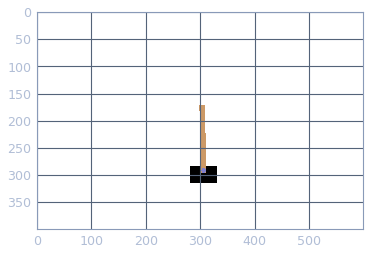

In [2]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, 'env'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [3]:
class PolicyApproximator(Model):
    def __init__(self, action_dim):
        super().__init__()
        self.d1 = Dense(16, activation='relu', name='dense1')
        self.d2 = Dense(8, activation='relu', name='dense2')
       # self.d3 = Dense(32, activation='relu', name='dense3')
       # self.d4 = Dense(16, activation='relu', name='dense4')
        self.d5 = Dense(2, activation='relu')

    def call(self, x):
        x = tf.expand_dims(x, 0)
        x = self.d1(x)
        x = self.d2(x)
     #   x = self.d3(x)
     #   x = self.d4(x)
        return self.d5(x)

In [4]:
def policy(states):
    return tf.nn.softmax(policy_approximator(states))

def log_policy(states):
    return tf.nn.log_softmax(policy_approximator(states))

def get_action_probs(states):
    log_action_probs = tf.squeeze(log_policy(states), 0)
    action_probs = tf.squeeze(policy(states), 0)
    return log_action_probs, action_probs

def get_cumulative_rewards(rewards,  gamma=0.99):
    cumulative_returns = np.zeros(len(rewards))
    G = 0
    for i in range(len(rewards) - 1, -1, -1):
        G = gamma * G + rewards[i]
        cumulative_returns[i] = G
    return cumulative_returns

def compute_objective(log_action_probs, actions, cumulative_returns):
    log_action_taken_probs = tf.gather_nd(log_action_probs, tf.stack([tf.range(log_action_probs.shape[0]), actions], axis=1))
    J = tf.math.reduce_mean(tf.math.multiply(log_action_taken_probs, cumulative_returns))
    return J

def compute_entropy(action_probs, log_action_probs):
    return - tf.math.reduce_sum(tf.math.multiply(action_probs, log_action_probs))



In [5]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions and rewards
    """

    # arrays to record session
    states, actions, rewards = np.asarray([], dtype='float32'), [], []
    s = env.reset().astype('float32')

    for t in range(t_max):

        # action probabilities and log probabilities
        log_action_probs, action_probs = get_action_probs(s)
        log_action_probs = log_action_probs.numpy().reshape(2,)
        action_probs = action_probs.numpy().reshape(2,)
        # choose an action
        action_t = np.random.choice([0, 1], p=action_probs)
        # perform a step
        new_s, r, done, info = env.step(action_t)

        # record session history to train later
        states = np.concatenate((states, s), axis=0)
        actions.append(action_t)
        rewards.append(r)

        s = new_s.astype('float32')
        if done:
            break
            
    return states.reshape(-1, s.shape[0]), actions, rewards

In [22]:
# Create an instance of the model
policy_approximator = PolicyApproximator(action_dim=env.action_space.n)

# Your code: define optimizers
optimizer = tf.keras.optimizers.Adam()

In [23]:
def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):

    # Gradient descent step
    with tf.GradientTape() as tape:
        # cast everything into tensorflow tensors
        states = tf.Variable(states, dtype='float32', name='states')
        actions = tf.Variable(actions, dtype='int32', name='actions')
        cumulative_returns = get_cumulative_rewards(rewards, gamma)
        cumulative_returns = tf.Variable(cumulative_returns, dtype='float32', name='cumulative_returns')
        
        # Compute action probs
        log_action_probs, action_probs = get_action_probs(states)
        
        # Compute entropy
        entropy = compute_entropy(log_action_probs, action_probs)
        
        # Compute objective
        J = compute_objective(log_action_probs, actions, cumulative_returns)
        loss = -J - entropy_coef * entropy
        
    
    gradients = tape.gradient(loss, policy_approximator.trainable_variables, )
    optimizer.apply_gradients(zip(gradients, policy_approximator.trainable_variables))        

    return np.sum(rewards)

In [24]:
global_rewards = []

for i in range(10000):

    rewards = train_on_session(*generate_session()[0:3]) # generate new sessions
    global_rewards.append(rewards)
    
    if i % 100 == 0:
        print("Episode number {} and the reward is {}".format(i,np.mean(global_rewards[-100:])))

    if np.mean(global_rewards[-100:]) > 300:
        print("You Win!")
        break

Episode number 0 and the reward is 35.0
Episode number 100 and the reward is 23.87
Episode number 200 and the reward is 25.17
Episode number 300 and the reward is 26.31
Episode number 400 and the reward is 34.98
Episode number 500 and the reward is 37.06
Episode number 600 and the reward is 50.49
Episode number 700 and the reward is 58.51
Episode number 800 and the reward is 71.7
Episode number 900 and the reward is 78.92
Episode number 1000 and the reward is 127.07
Episode number 1100 and the reward is 153.26
Episode number 1200 and the reward is 137.27
Episode number 1300 and the reward is 143.98
Episode number 1400 and the reward is 172.35
Episode number 1500 and the reward is 143.38
Episode number 1600 and the reward is 148.83
Episode number 1700 and the reward is 256.84
Episode number 1800 and the reward is 228.65
Episode number 1900 and the reward is 262.15
Episode number 2000 and the reward is 215.34
Episode number 2100 and the reward is 241.93
Episode number 2200 and the reward

In [27]:
policy_approximator.save_weights('model_weights/trained_policy_REINFORCE')

In [28]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [30]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices